# Sheerwater Walkthrough

This example walks through accessing data in sheerwater, computing a metric manually, then comparing that metric to one we've already comptued in Sheerwater. We also walk through strategies for faster data access and talk about the sheerwater data storage system - Nuthatch

## Data storage system and philosophy

Because sheerwater transforms terra- and sometimes peta-byte scale datasets, we built a tool, [Nuthatch](github.com/rhiza-research/nuthatch),
to store, recall, and slice these datasets and enable more efficient access and computation.  In Nuthatch, the results of functions
are stored in data-type specific caches based on the function name and the arguments that are passed. When the same function is called with
the same key arguments, the data is returned rather than running the function. Datasets are stored in "global" caches in the cloud,
and can also be sliced down in time and space to be saved to your machine for faster access.
 
When you install Sheerwater, your environment is automatically configured to access all of Sheerwater's public data through Nuthatch.
Therefore when you call Sheerwater functions, you will mostly just be hitting pre-computed results, but the code serves as a self-documenting
API of how the data was transformed from its source to the result and enables users with enough compute to rerun the code either for
purposes of verification or to compute the functions with arguments that have not already been computed and stored.

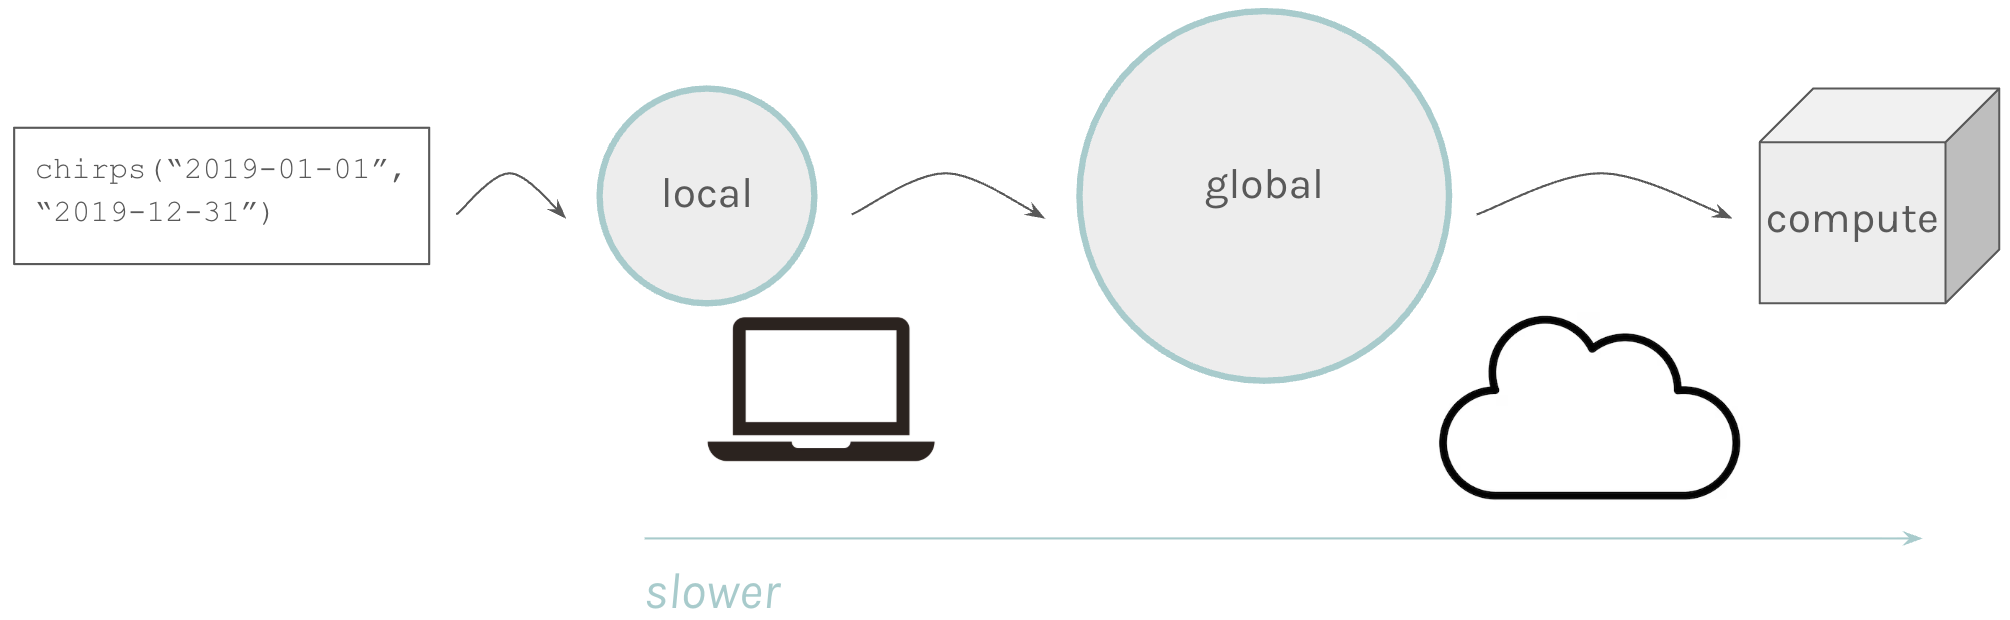

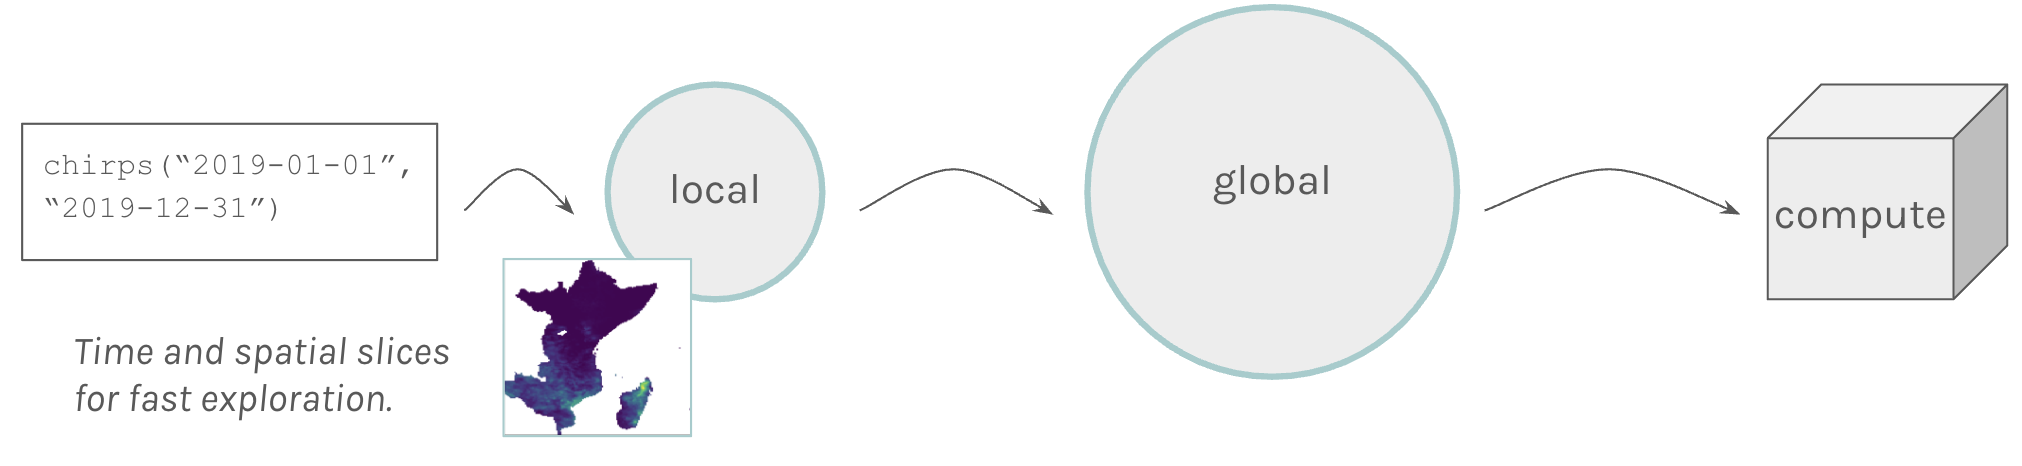

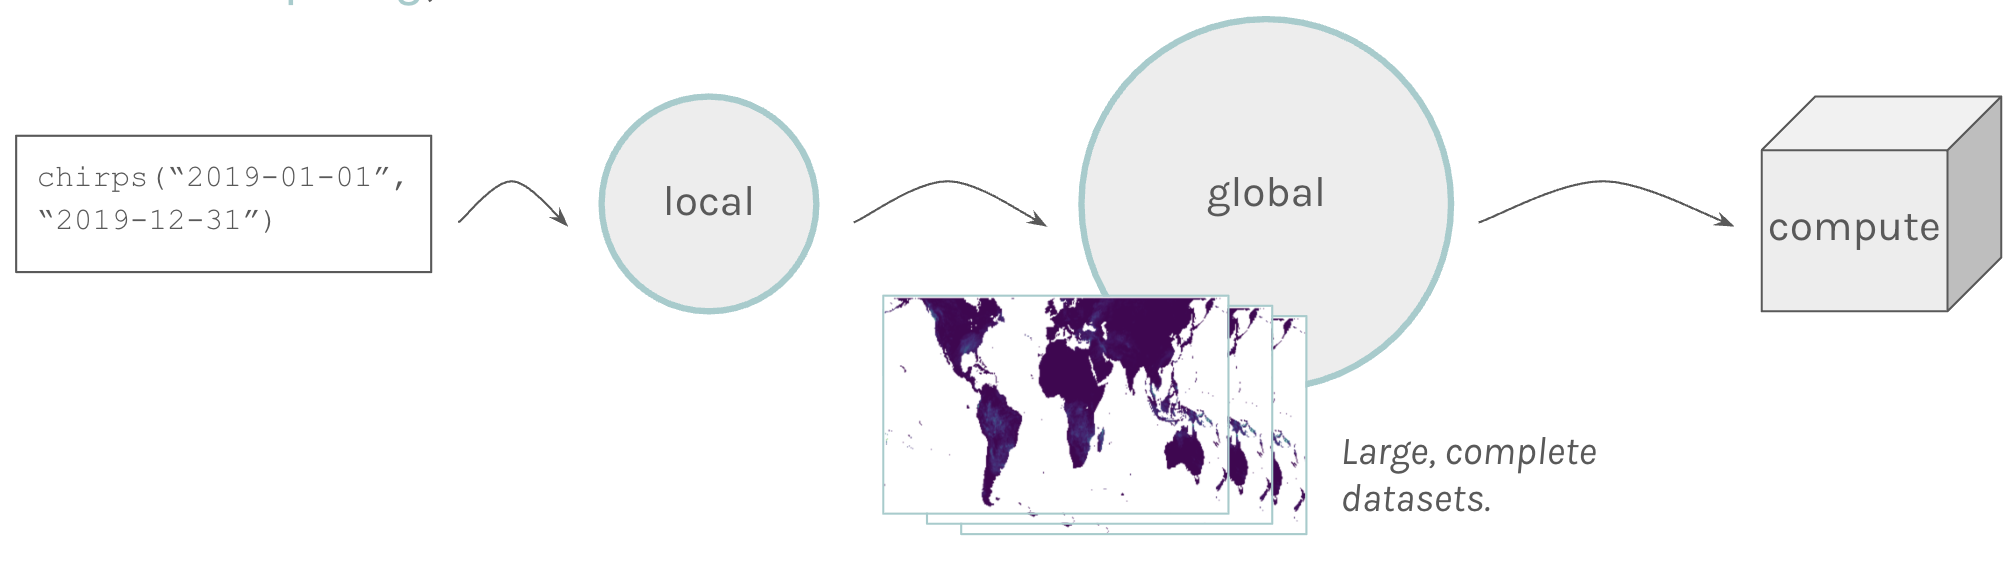

## Sheerwtaer can be installed from pip

In [ ]:
%pip install sheerwater

## First data access

In this example we access the IMERG dataset, aggregated on a 7 day rolling window on a global 0.25x0.25 grid in Africa.

Datasets are available at many grids and aggregations as specified in the README of this repo.

In [ ]:
import numpy as np

%matplotlib inline

from sheerwater.data import imerg
from sheerwater.forecasts import ecmwf_ifs_er_debiased
from sheerwater.metrics import metric

In [ ]:
start_time = "2019-01-01"
end_time = "2019-12-31"

## Datset slicing and local storage

While the IMERG dataset is available from 1998 to present, we use the start_time, and end_time arguments to access a smaller slice. We also set `region="africa"` to select only the data in Africa.

After fetching this subset of the IMERG data, setting `cache_mode='local'` instructs Nuthatch to save this data locally. The first time you call this, you may need to read a few hundred MB of data from the cloud, but repeated calls to this same function will hit your local storage instead.

All data in Sheerwater is stored in Xarray with time, lat, and lon dimensions on a set of standard grids.

In [ ]:
%%time
ds = imerg(start_time, end_time, agg_days=7, grid='global0_25', mask="lsm", region="africa", cache_mode='local')
ds.precip.sel(time="2019-05-27").plot(x='lon')

## Accessing the data on a 1.5 x 1.5 Grid

We access the data on a 1.5x1.5 grid that aligns with the ECMWF IFS ER grid so that we can compare the two.

In [ ]:
%%time
ds_truth = imerg(start_time, end_time, agg_days=7, grid='global1_5', mask="lsm", region="africa", cache_mode='local')
ds_truth.precip.sel(time="2019-05-27").plot(x='lon')

## Accessing ECMWF IFS ER Debiased

Sheerwater has already has the debiased versions of ECMWF IFS ER. We get it on the same grid, region, and time as IMERG data above and
save it locally as well for fast repeated access.

In [ ]:
%%time
ds_fcst = ecmwf_ifs_er_debiased(start_time, end_time, grid='global1_5', agg_days=7, mask="lsm", region="africa", cache_mode='local')
ds_fcst

### Note: Forecast data format

All forecast data in sheerwater is stored in Xarray with time, lat, lon, and prediction_timedelta dimensions. Our ECMWF forecast has 6 leads for each week of the forecast. An example of selecting the 21 day lead is below.

In [ ]:
lead = np.timedelta64(21, 'D')
ds_fcst.precip.sel(time="2019-05-27", prediction_timedelta=lead).plot(x='lon')

#### We can plot the errors between the IMERG and ECWMF IFS ER at a specific date

In [ ]:
error = ds_truth - ds_fcst
error.isel(prediction_timedelta=3).sel(time="2019-05-27").precip.plot(x='lon')

#### And also compute the _unweighted_ MAE between the two for the year for each of the 6 weeks in the ECMWF IFS ER Forecast

In [ ]:
mae_computed = np.abs(error).mean(dim=['lat', 'lon', 'time'])
print("Unweighted error of", mae_computed.precip.values, "mm / day of rainfall")

#### All sheerwater metrics are latitude weighted. The following code computes the latitude weighted MAE between IMERG and ECMWF IFS ER

In [ ]:
from sheerwater.utils import latitude_weights
weights = latitude_weights(error)
weights = weights.where(error.notnull(), np.nan, drop=False)
weights.precip.isel(time=0, prediction_timedelta=0).plot(x='lon')

In [ ]:
mae_weighted = (((np.abs(error) * weights).sum(dim=['lat', 'lon'])) / weights.sum(dim=['lat', 'lon'])).mean(dim='time')
print("Weighted error of", mae_weighted.precip.values, "mm / day of rainfall")

## Computing a metric with the sheerwater metrics library

We can now compare our metric code the that computed by the sheerwater metrics library. The metrics library takes all the same arguments as the forecasts and data, but you pass in the forecast and truth source to compare as strings.

Forecasts and other data sources are registered by name in the sheerwater library. You can see what is registered like so:

In [ ]:
from sheerwater.interfaces import list_forecasts, list_data
print(list_forecasts())
print(list_data())

### Now we can compute the same metric as above and verify that the weighted MAE for this time and space region match

In [ ]:
mae_sheerwater = metric(start_time, end_time, "precip", agg_days=7,
                        forecast="ecmwf_ifs_er_debiased",
                        truth="imerg",
                        metric_name="mae",
                        grid="global1_5",
                        mask="lsm",
                        region="africa",
                        cache_mode='local')

In [ ]:
mae_sheerwater.mae.values

#### This is slightly different than the unweighted MAE we first computed

In [ ]:
print("Unweighted error of", mae_computed.precip.values, "mm / day of rainfall")

## Registering your own forecast for evaluation

You can register your own forecast to be evaluated with the evaluation library as well. Forecasts are expected to adhere to the interface below.

In [ ]:
from sheerwater.interfaces import forecast, data
import xarray as xr

@forecast()
def my_new_forecast(start_time=None, end_time=None, variable="precip", agg_days=1, prob_type='deterministic',
                    grid='global1_5', mask='lsm', region="africa"):
    # Must return lat/lon/time/prediction_timedelta and possibly member for the specified variable, grid, aggregation, and prob_type
    # the forecast decorator handles time slicing, masking and region slicing
    return xr.ones_like(ds_fcst)

In [ ]:
from sheerwater.interfaces import forecast

@data()
def my_new_data(start_time=None, end_time=None, variable="precip", agg_days=1,
                    grid='global1_5', mask='lsm', region="africa"):
    # Must return lat/lon/time/prediction_timedelta and possibly member for the specified variable, grid, aggregation, and prob_type
    # the forecast decorator handles time slicing, masking and region slicing
    return xr.ones_like(ds_truth)*2

In [ ]:
new_mae = metric(start_time, end_time, "precip", agg_days=7,
                        forecast="my_new_forecast",
                        truth="my_new_data",
                        metric_name="mae",
                        grid="global1_5",
                        mask="lsm",
                        region="africa",
                        cache_mode='local')

In [ ]:
new_mae.mae.values